In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

In [47]:
df = pd.read_csv('/Users/arun/Downloads/HR_comma_sep.csv')

In [48]:
df.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

Initial EDA and data cleaning

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [50]:
df.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [51]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [52]:
df.duplicated().sum()

np.int64(3008)

In [53]:
df[df.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_montly_hours  time_spend_company  Work_accident  left  \
396                    139                   3              0     1   
866                    128                   3              0     1   
1317                   127                   3              0     1   
1368                   132                   3              0     1   
1461                   142                   3              0     1   

      promotion_last_5years  Department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

In [54]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [55]:
df = df.rename(columns={
    'average_montly_hours' : 'average_monthly_hours',
    'time_spend_company' : 'tenure',
    'Work_accident' : 'work_accident',
    'Department' : 'department'
})

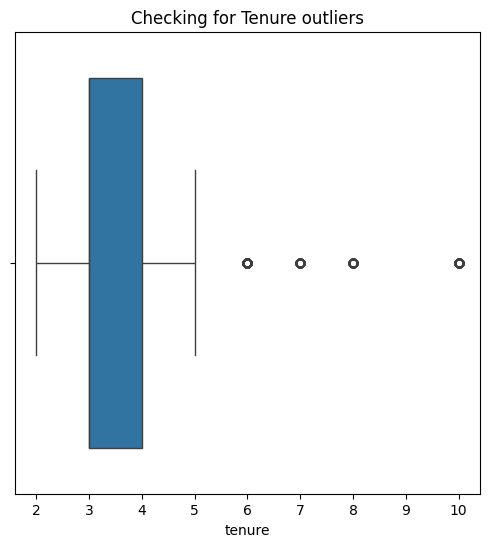

In [56]:
plt.figure(figsize=(6,6))
plt.title('Checking for Tenure outliers', fontsize = 12)
sns.boxplot(x=df['tenure'])
plt.show()

In [57]:
# Check for number of outliers

percentile25 = df['tenure'].quantile(0.25)
percentile75 = df['tenure'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + iqr*1.5
lower_limit = percentile25 - iqr*1.5
print(f'Lower Limit: {lower_limit}')
print(f'Upper Limit: {upper_limit}')
outliers = df[(df['tenure'] < lower_limit) | (df['tenure'] > upper_limit)]
print('No. of outliers in tenure is:',len(outliers))

Lower Limit: 1.5
Upper Limit: 5.5
No. of outliers in tenure is: 824


In [58]:
df['left'].value_counts(normalize = True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

Plotting Visualizations

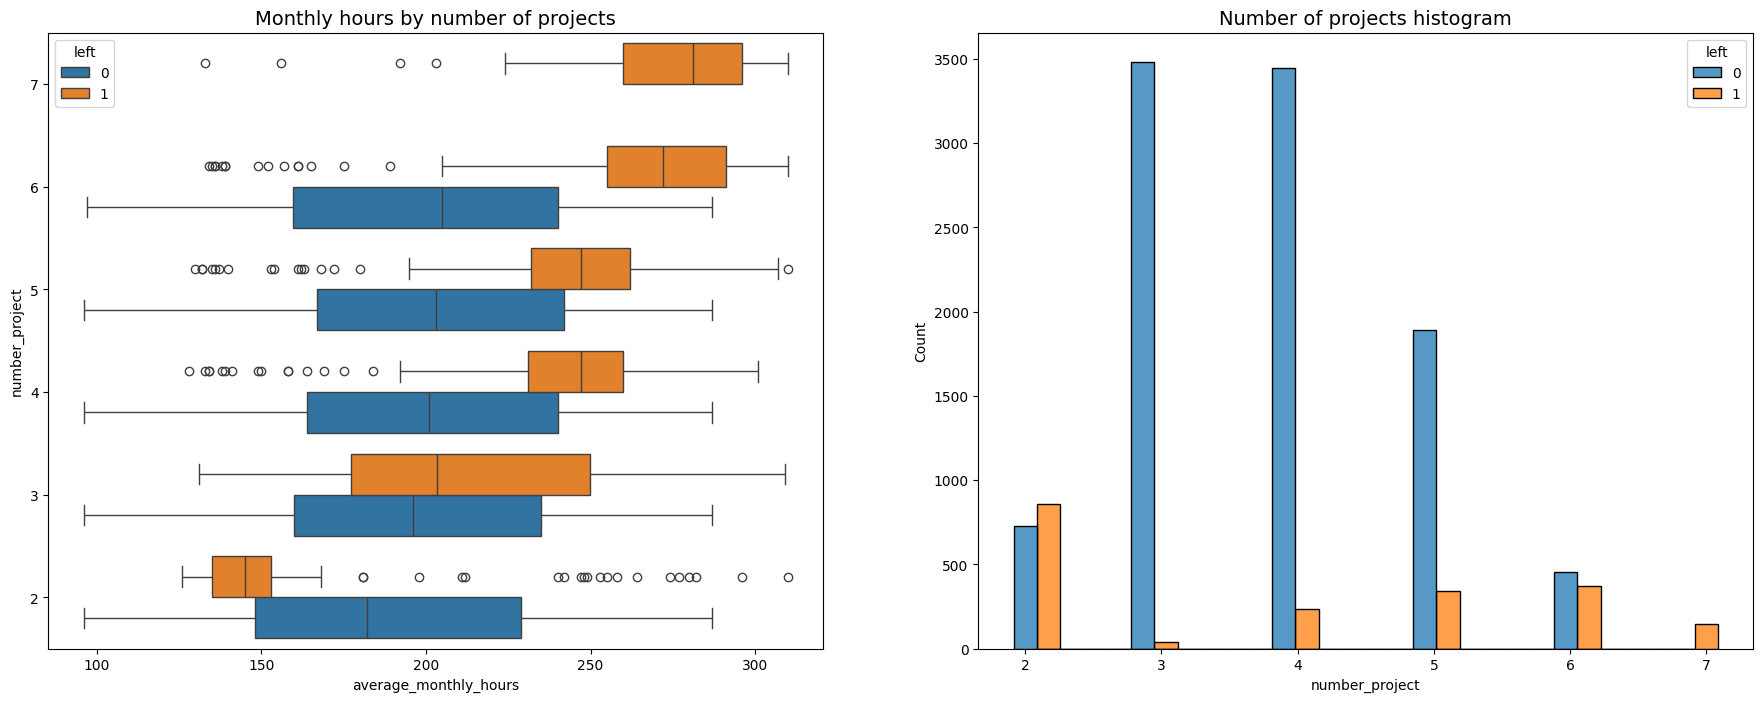

In [59]:


fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

tenure_stay = df[df['left']==0]['number_project']
tenure_left = df[df['left']==1]['number_project']
sns.histplot(data=df, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')
plt.show()

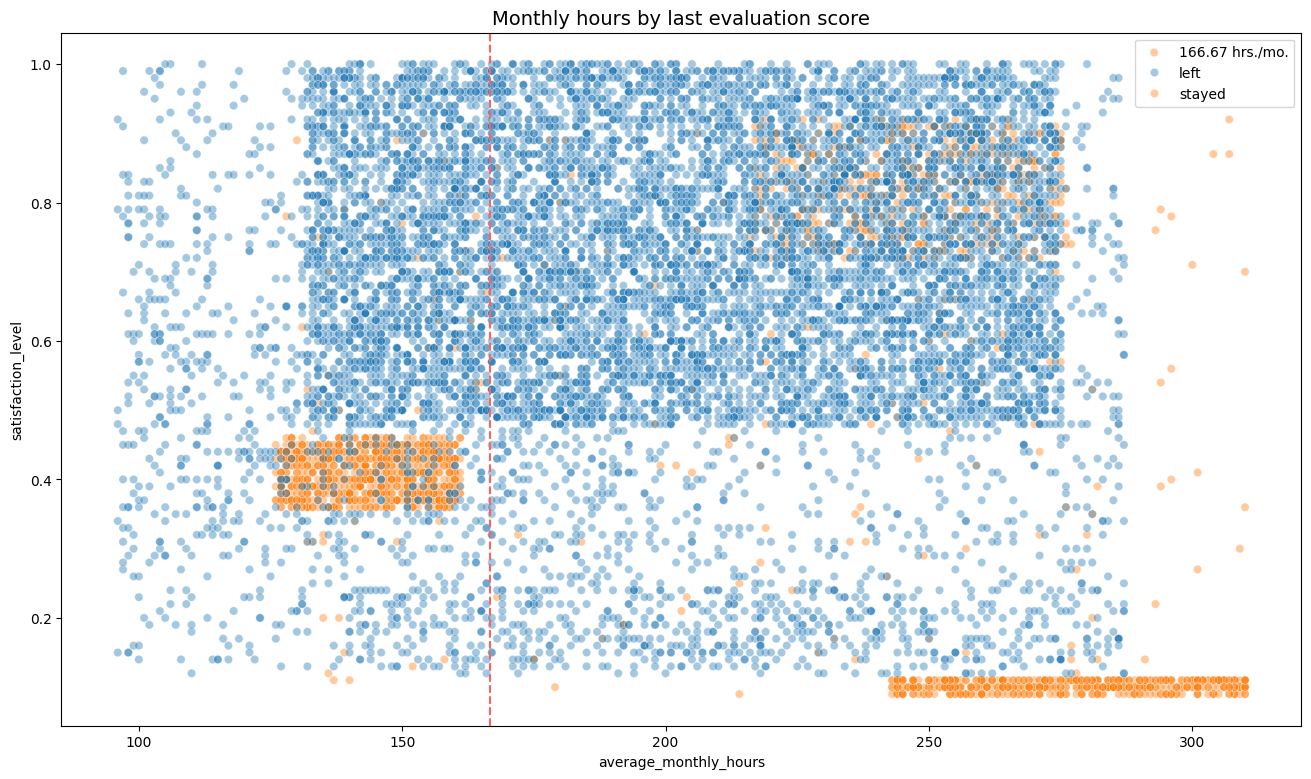

In [60]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

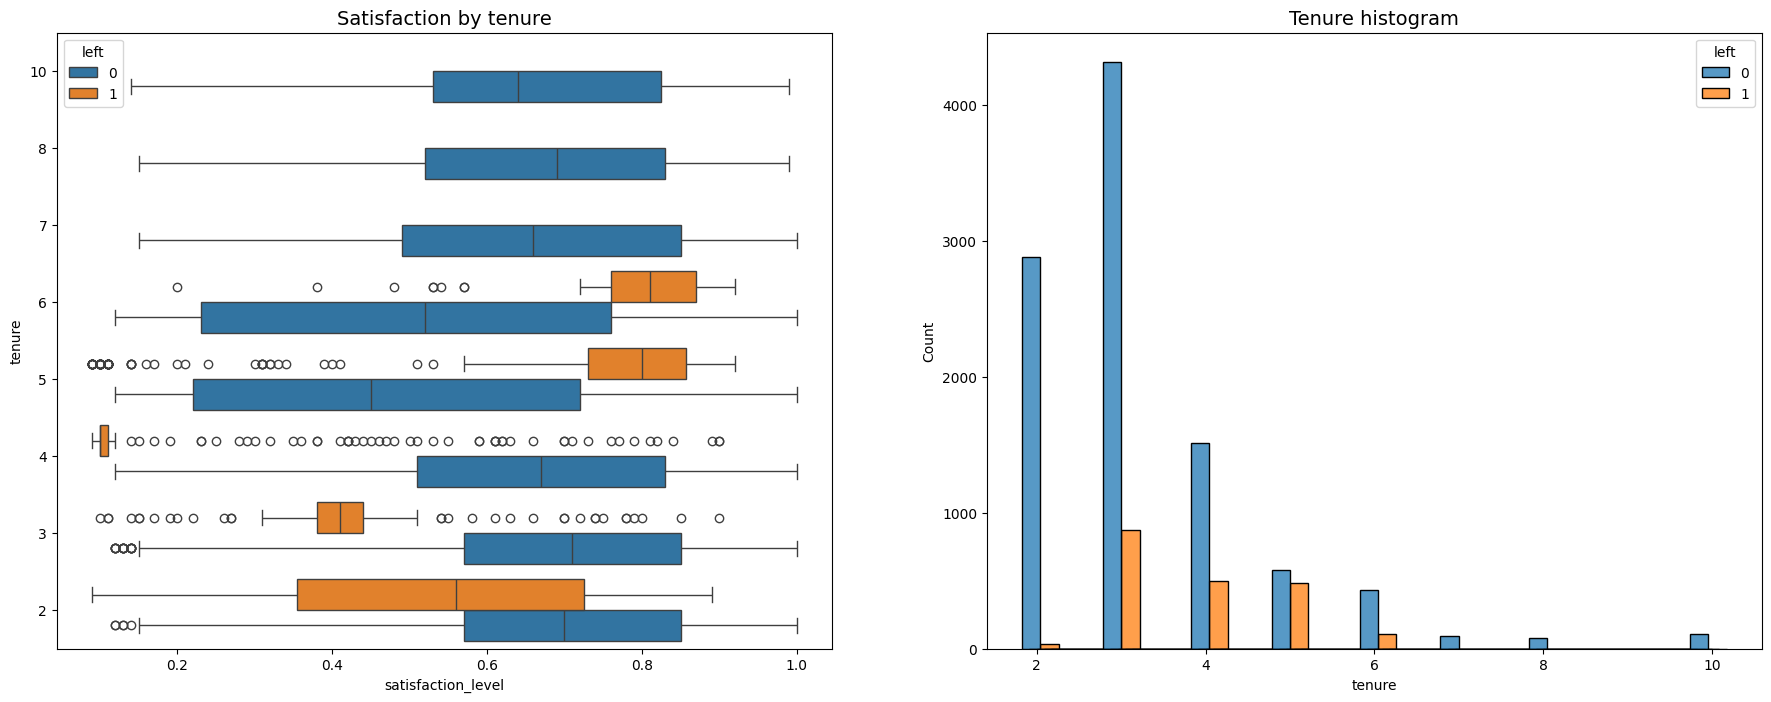

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

sns.histplot(data=df, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

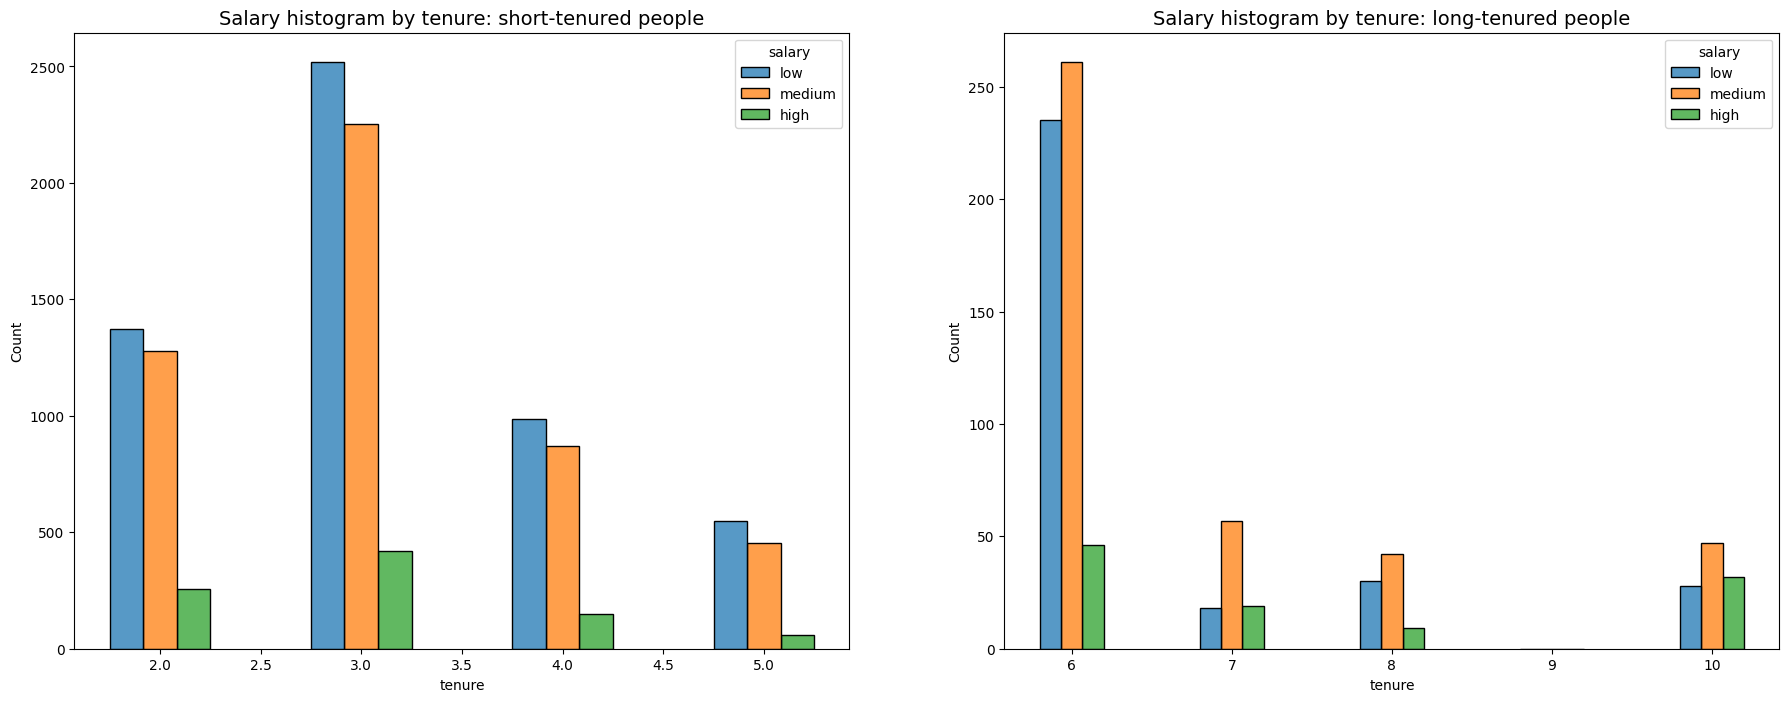

In [62]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df[df['tenure'] < 6]

# Define long-tenured employees
tenure_long = df[df['tenure'] > 5]

sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

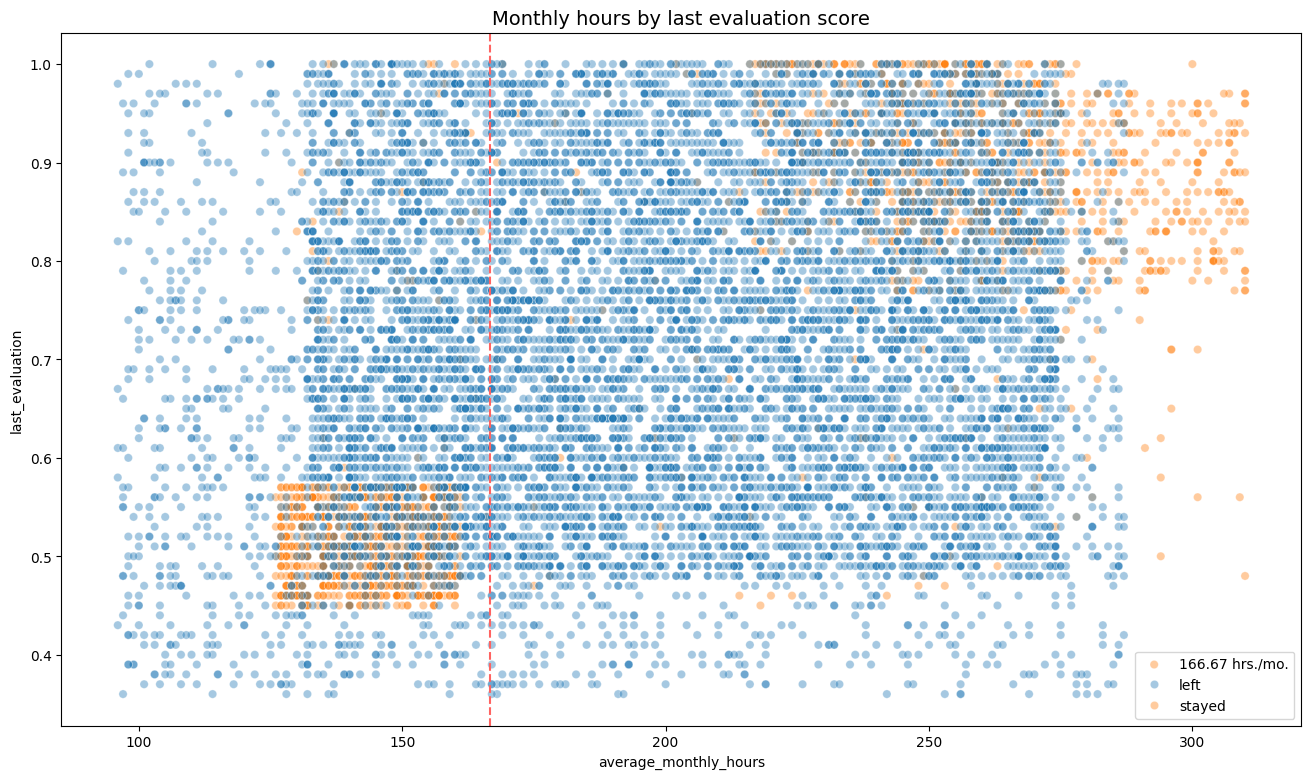

In [63]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

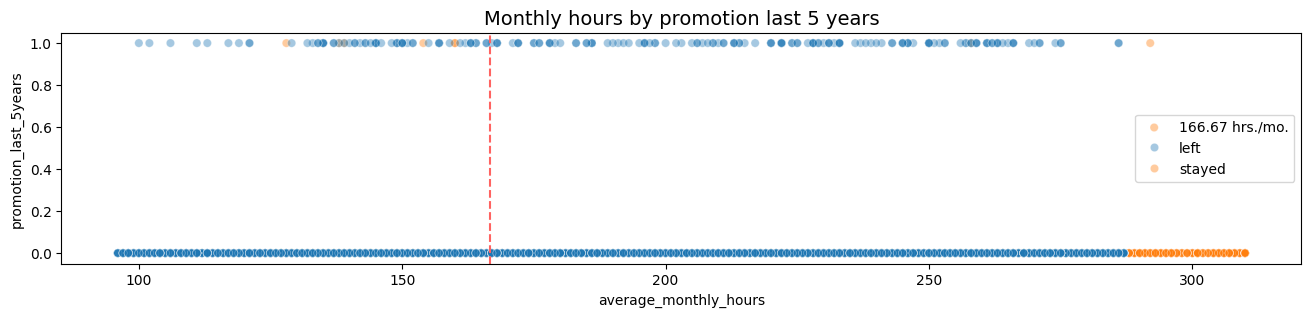

In [64]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

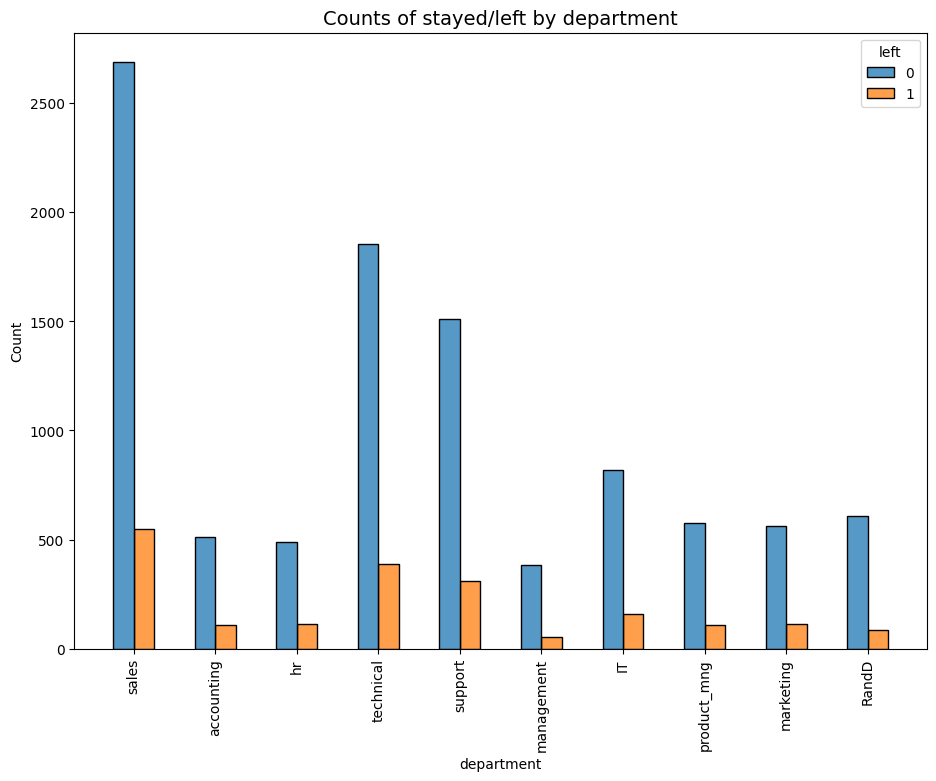

In [65]:
plt.figure(figsize=(11,8))
sns.histplot(data=df, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);

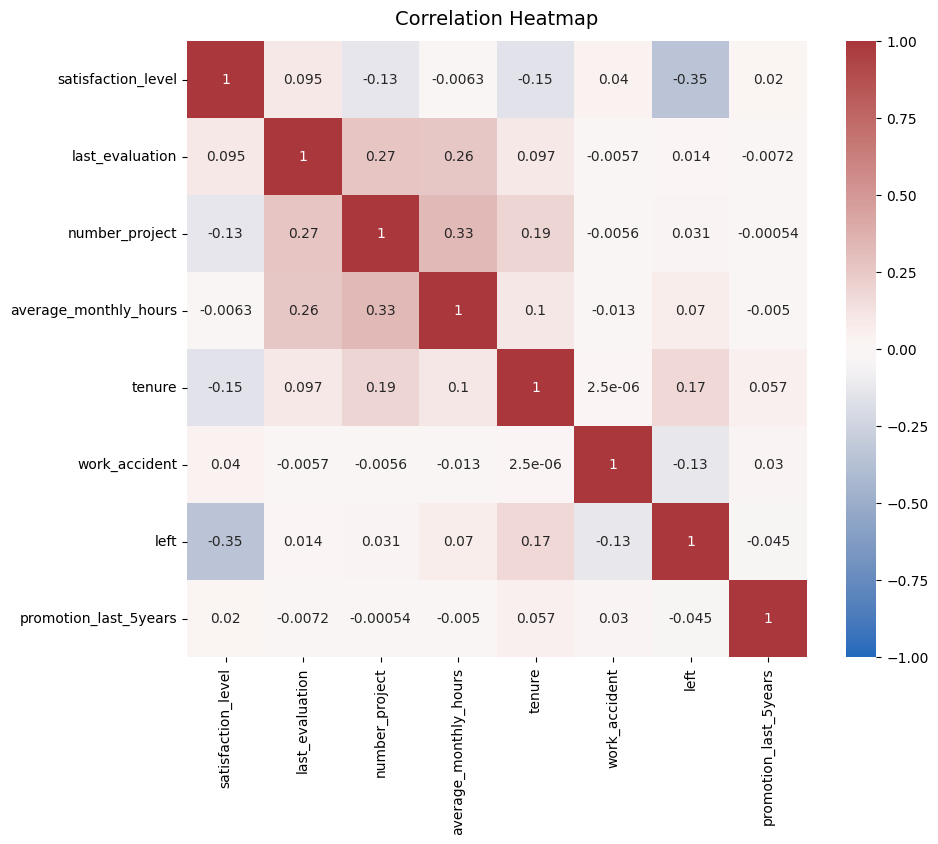

In [66]:
#check for correlations

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

Building Logistic Regression Model

In [67]:
df_enc = df.copy()

In [68]:
#converting categorical variables to numerals

df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df_enc = pd.get_dummies(df_enc, drop_first=False)

columns_to_convert = ['department_IT',                
'department_RandD',           
'department_accounting',       
'department_hr',            
'department_management',    
'department_marketing',
'department_product_mng', 
'department_sales',           
'department_support',          
'department_technical']
df_enc[columns_to_convert] = df_enc[columns_to_convert].astype(int)

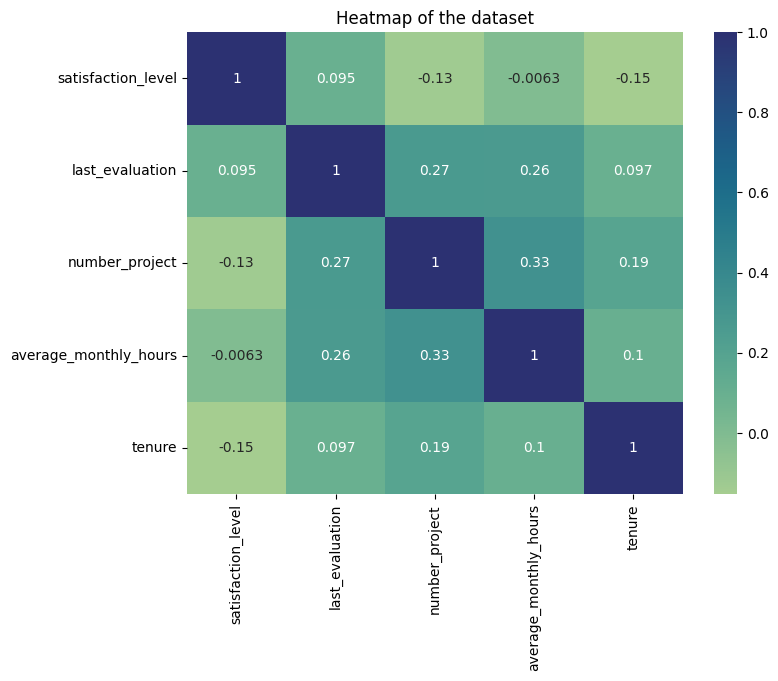

In [69]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [70]:
# Since Logistic Regression is sensitive to outliers, removing them
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]


In [71]:
y = df_logreg['left']
X = df_logreg.drop('left',axis=1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.25, stratify=y, random_state=42)

In [73]:
log_clf = LogisticRegression(random_state=42, max_iter=5000).fit(X_train, y_train)

In [74]:
y_pred = log_clf.predict(X_test)

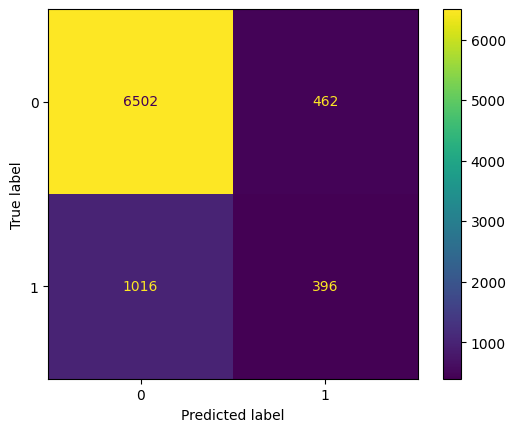

In [75]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)
log_disp.plot(values_format='')
plt.show()

In [76]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      6964
    Predicted would leave       0.46      0.28      0.35      1412

                 accuracy                           0.82      8376
                macro avg       0.66      0.61      0.62      8376
             weighted avg       0.80      0.82      0.81      8376



Tree-Based Models

In [77]:
#Feature Engineering
df_tree = df_enc.drop('satisfaction_level', axis=1)
df_tree['overworked'] = df_tree['average_monthly_hours']
df_tree['overworked'] = (df_tree['overworked'] > 175).astype(int)
df_tree = df_tree.drop('average_monthly_hours', axis=1)

In [78]:
df_tree.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0              0                 0   
1                      0       1              0                 0   
2                      0       1              0                 0   
3                      0       0              0                 0   
4                      0       0              0                 0   

   department_accounting  department_hr  department_management  \
0                      0              0                      0   
1                      0              0                      0   
2                      0              0                      0   
3                      0              0                      0   
4                      0              0                      0   

   department_marketing  department_product_mng  department_sales  \
0                     0                       0                 1   
1                     0                       0                 1   
2                     0                       0                 1   
3                     0                       0                 1   
4                     0                       0                 1   

   department_support  department_technical  overworked  
0                   0                     0           0  
1                   0                     0           1  
2                   0                     0           1  
3                   0                     0           1  
4                   0                     0           0

In [79]:
y = df_tree['left']
X = df_tree.drop('left', axis=1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

In [81]:
tree = DecisionTreeClassifier(random_state=0)
cv_params = {
    'max_depth':[4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
}
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tree1 = GridSearchCV(tree,cv_params,scoring=scoring,cv=4,refit='roc_auc')

In [89]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 1.61 s, sys: 15.4 ms, total: 1.62 s
Wall time: 1.67 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [90]:
# Check best parameters
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [91]:
def make_results(model_name:str, model_object, metric:str):
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
    return table

In [92]:
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision   recall        F1  accuracy       auc
0  decision tree cv   0.842295  0.88542  0.862673  0.952297  0.957096

Buliding a RandomForest as DecisionTrees are prone to overfitting

In [93]:
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [50, 100],
             }  
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [94]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 1min 46s, sys: 606 ms, total: 1min 47s
Wall time: 1min 48s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [95]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

In [96]:
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision   recall        F1  accuracy       auc
0  decision tree cv   0.842295  0.88542  0.862673  0.952297  0.957096
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.865513  0.892685  0.878797  0.958412  0.966038


In [97]:
def get_scores(model_name:str, model, X_test_data, y_test_data):

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [99]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest test', rf1, X_test, y_test)
rf1_test_scores

model  precision    recall        f1  accuracy       AUC
0  random forest test   0.856859  0.913136  0.884103  0.962308  0.942316

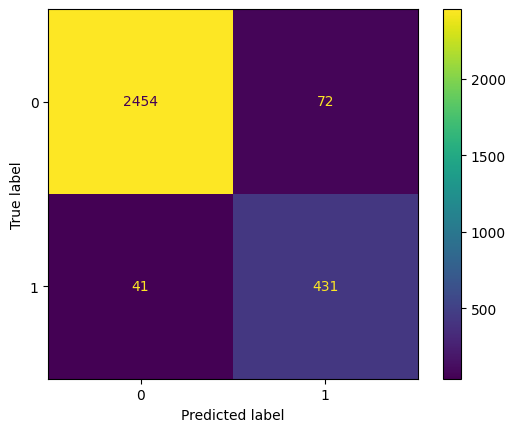

In [102]:
preds = rf1.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_)
disp.plot(values_format='');

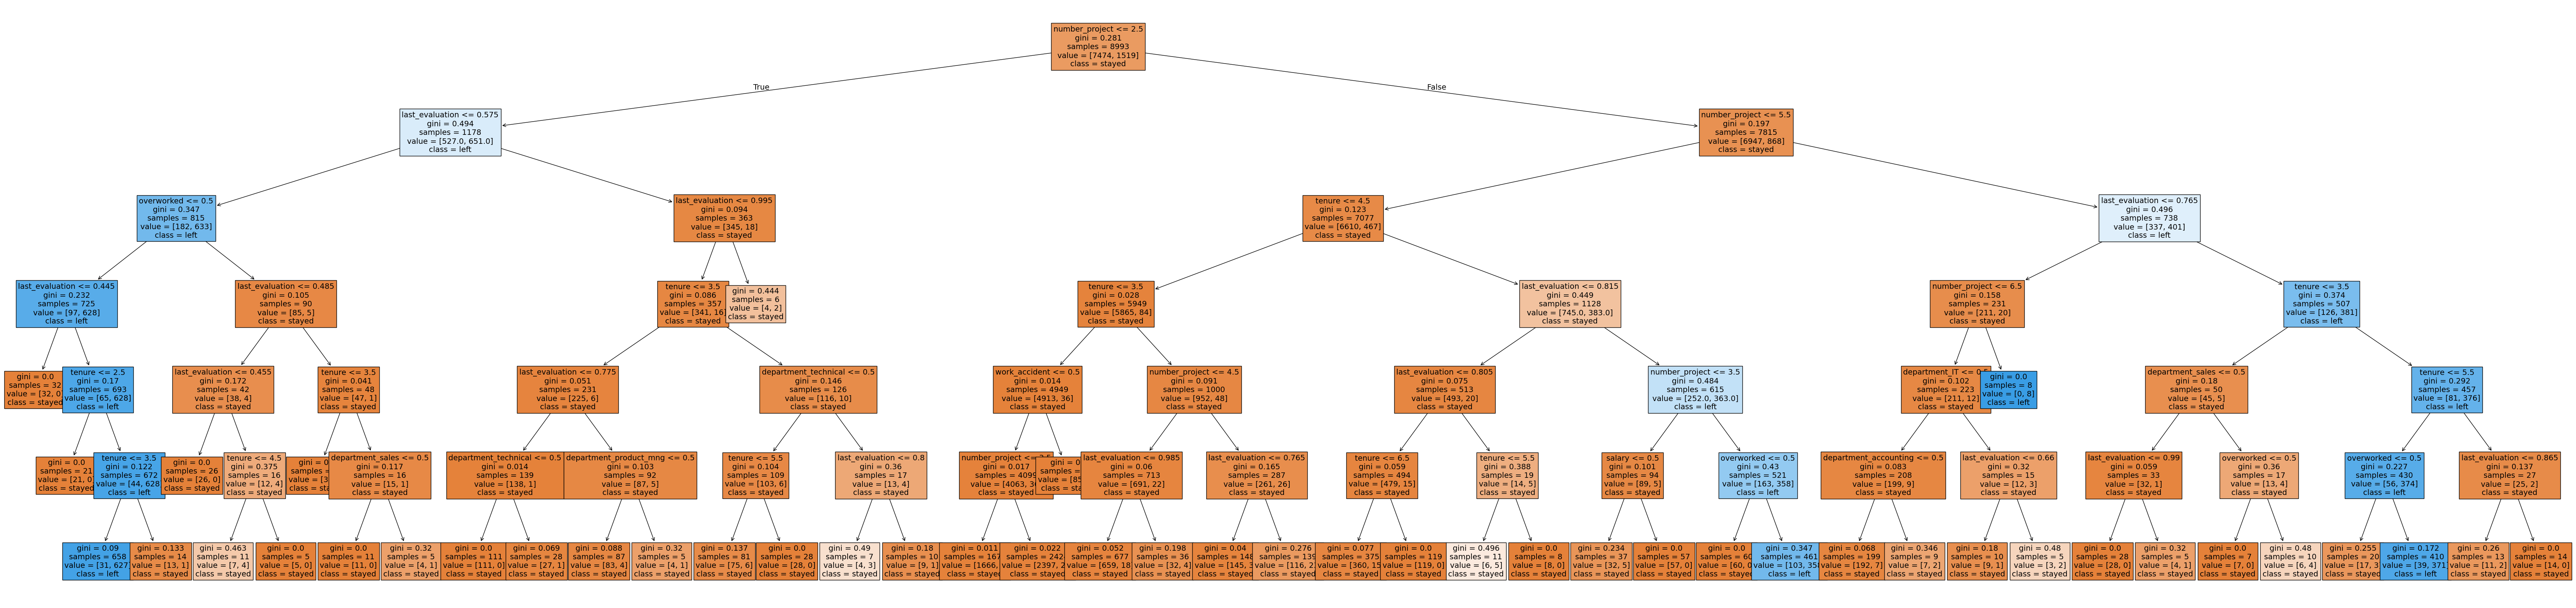

In [103]:
plt.figure(figsize=(85,20))
plot_tree(tree1.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [109]:
tree1_importances = pd.DataFrame(tree1.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree1_importances = tree1_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree1_importances = tree1_importances[tree1_importances['gini_importance'] != 0]
tree1_importances

gini_importance
number_project                 0.399531
last_evaluation                0.324687
tenure                         0.175290
overworked                     0.098109
department_sales               0.000621
department_technical           0.000517
salary                         0.000418
department_IT                  0.000351
department_accounting          0.000307
department_product_mng         0.000114
work_accident                  0.000055

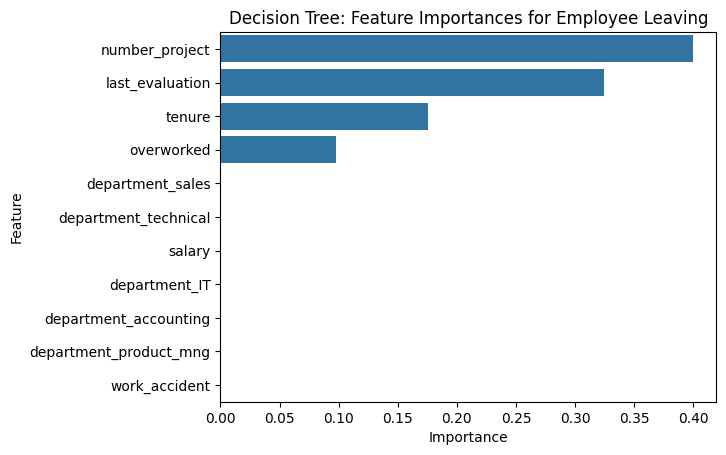

In [110]:
sns.barplot(data=tree1_importances, x="gini_importance", y=tree1_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

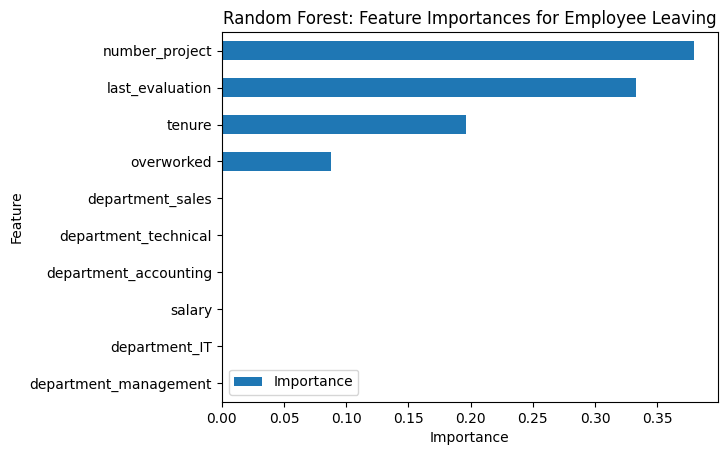

In [111]:
# Get feature importances
feat_impt = rf1.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf1.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()